In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Load the data
train_data = pd.read_csv('/Users/nadaalqabbani/Documents/GitHub/Riyadh-Electric-Load-forecasting/data/train_data.csv')
test_data = pd.read_csv('/Users/nadaalqabbani/Documents/GitHub/Riyadh-Electric-Load-forecasting/data/test_data.csv')

# Convert 'date' to datetime and set as index
train_data['date'] = pd.to_datetime(train_data['date'])
test_data['date'] = pd.to_datetime(test_data['date'])
train_data.set_index('date', inplace=True)
test_data.set_index('date', inplace=True)

# Convert 'preciptype' column to numeric (1 for 'rain', 0 for not 'rain')
train_data['preciptype'] = train_data['preciptype'].apply(lambda x: 1 if x == 'rain' else 0)
test_data['preciptype'] = test_data['preciptype'].apply(lambda x: 1 if x == 'rain' else 0)

# Handle missing values
numeric_columns = train_data.select_dtypes(include=[np.number]).columns
train_data[numeric_columns] = train_data[numeric_columns].fillna(train_data[numeric_columns].median())
test_data[numeric_columns] = test_data[numeric_columns].fillna(test_data[numeric_columns].median())



# Separate features and target
X_train = train_data.drop(columns=['electric_load'])
y_train = train_data['electric_load']
X_test = test_data.drop(columns=['electric_load'])
y_test = test_data['electric_load']

# Normalize features
feature_scaler = MinMaxScaler()
X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)

# Normalize target
target_scaler = MinMaxScaler()
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1))

# Split the training data into training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train_scaled, y_train_scaled, test_size=0.2, random_state=42)

# Reshape data to fit LSTM input requirements [samples, time steps, features]
X_train_split = X_train_split.reshape((X_train_split.shape[0], 1, X_train_split.shape[1]))
X_val_split = X_val_split.reshape((X_val_split.shape[0], 1, X_val_split.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))


/Users/nadaalqabbani/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
from tensorflow.keras.layers import Conv1D
# Build a Convolutional + LSTM + GRU model
model = Sequential()
model.add(Input(shape=(X_train_split.shape[1], X_train_split.shape[2])))

# Convolutional Layer
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))

# LSTM Layers
model.add(Bidirectional(LSTM(units=50, return_sequences=True, kernel_initializer='he_normal')))
model.add(Dropout(0.3))  # Dropout rate adjusted for the combined model

# GRU Layer
model.add(Bidirectional(GRU(units=50, return_sequences=False, kernel_initializer='he_normal')))
model.add(Dropout(0.3))  # Dropout rate adjusted for the combined model

model.add(Dense(units=25, activation='relu'))
model.add(Dense(units=1))

# Compile the model with gradient clipping
optimizer = Adam(learning_rate=0.0001, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Callbacks for training
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.00001)
]

# Model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 1, 64)          │         3,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 1, 100)         │        46,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 100)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 100)            │        45,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         2,525 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 97,671 (381.53 KB)

 Trainable params: 97,671 (381.53 KB)

 Non-trainable params: 0 (0.00 B)

In [3]:
# Train the model
history = model.fit(X_train_split, y_train_split, epochs=50, batch_size=32, validation_data=(X_val_split, y_val_split), shuffle=False, callbacks=callbacks)


Epoch 1/50
9456/9456 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 0.0136 - val_loss: 0.0046 - learning_rate: 1.0000e-04
Epoch 2/50
9456/9456 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 0.0050 - val_loss: 0.0041 - learning_rate: 1.0000e-04
Epoch 3/50
9456/9456 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - loss: 0.0044 - val_loss: 0.0040 - learning_rate: 1.0000e-04
Epoch 4/50
9456/9456 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - loss: 0.0042 - val_loss: 0.0038 - learning_rate: 1.0000e-04
Epoch 5/50
9456/9456 ━━━━━━━━━━━━━━━━━━━━ 14s 1ms/step - loss: 0.0040 - val_loss: 0.0037 - learning_rate: 1.0000e-04
Epoch 6/50
9456/9456 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - loss: 0.0039 - val_loss: 0.0036 - learning_rate: 1.0000e-04
Epoch 7/50
9456/9456 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - loss: 0.0038 - val_loss: 0.0035 - learning_rate: 1.0000e-04
Epoch 8/50
9456/9456 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - loss: 0.0037 - val_loss: 0.0034 - learning_rate: 1.0000e-04
Epoch 9/50
9456/9456 ━━━━━━━━━━━━━━━━━━━━ 13s 1ms/step - loss: 0

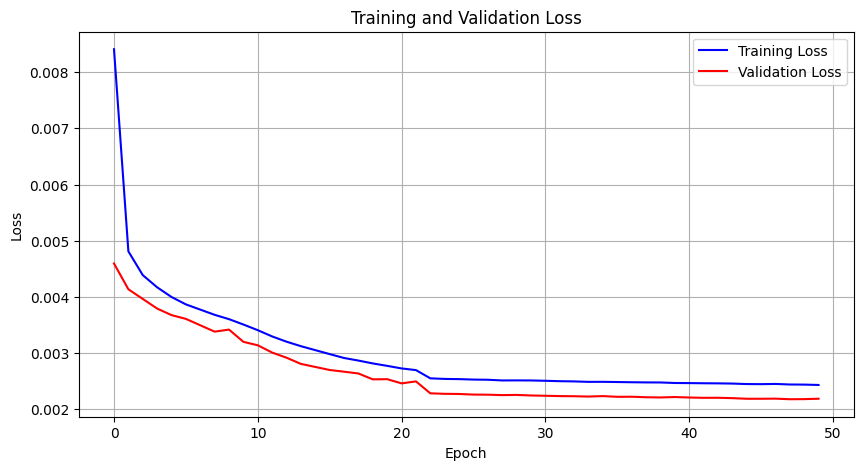

In [4]:
import matplotlib.pyplot as plt
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [5]:

# Evaluate the model
loss = model.evaluate(X_test_scaled, y_test_scaled)
print(f'Model Loss: {loss}')

# Make predictions
predictions = model.predict(X_test_scaled)

# Inverse transform the predictions
predictions = target_scaler.inverse_transform(predictions)

# Compare predictions with actual values
actual_values = y_test.values
predicted_values = predictions[:, 0]

# Print out the first 10 actual and predicted values
for i in range(10):
    print(f'Actual: {actual_values[i]}, Predicted: {predicted_values[i]}')

932/932 ━━━━━━━━━━━━━━━━━━━━ 1s 408us/step - loss: 0.0042
Model Loss: 0.01011656504124403
932/932 ━━━━━━━━━━━━━━━━━━━━ 1s 653us/step
Actual: 11553.30078125, Predicted: 12083.26953125
Actual: 11545.556640625, Predicted: 11998.4541015625
Actual: 11615.314453125, Predicted: 11923.638671875
Actual: 11636.837890625, Predicted: 11848.2490234375
Actual: 11678.97265625, Predicted: 11777.2177734375
Actual: 11647.173828125, Predicted: 11708.95703125
Actual: 11670.513671875, Predicted: 11640.2158203125
Actual: 11679.2109375, Predicted: 11570.990234375
Actual: 11656.509765625, Predicted: 11501.2802734375
Actual: 11582.3349609375, Predicted: 11431.62109375


In [6]:
# Calculate RMSE for the test set
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error


rmse = np.sqrt(mean_squared_error(y_test, predicted_values))


# Create a DataFrame for the metrics


# Print the metrics table


# Calculate MAPE
mape = mean_absolute_percentage_error(actual_values, predictions)

metrics_df = pd.DataFrame({
    'Metric': ['RMSE', 'MAPE'],
    'Value': [rmse, mape * 100]  # MAPE is multiplied by 100 to convert it to a percentage
})

# Print the DataFrame
print(metrics_df)


  Metric        Value
0   RMSE  1844.789210
1   MAPE    11.149039


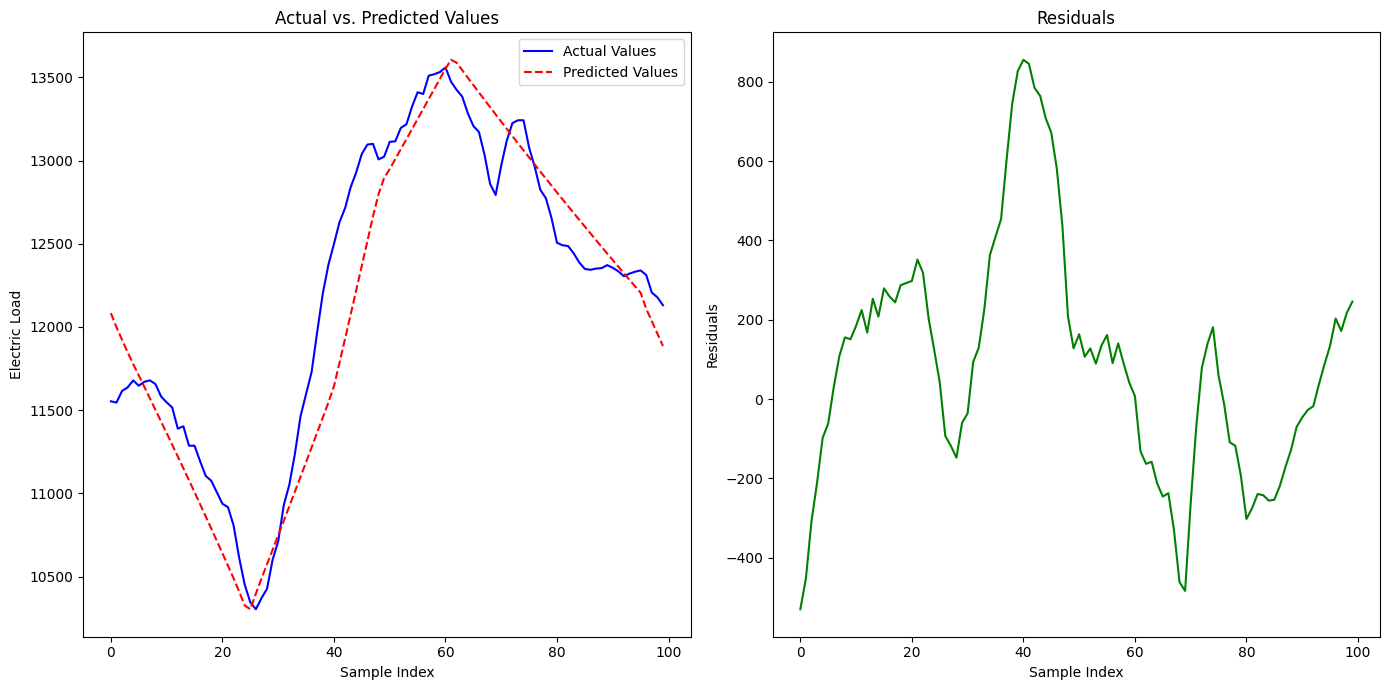

In [7]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(14, 7))

# Plot actual vs. predicted values
plt.subplot(1, 2, 1)
plt.plot(actual_values[:100], label='Actual Values', color='blue')
plt.plot(predicted_values[:100], label='Predicted Values', color='red', linestyle='--')
plt.title('Actual vs. Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Electric Load')
plt.legend()

# Plot residuals
residuals = actual_values - predicted_values
plt.subplot(1, 2, 2)
plt.plot(residuals[:100], color='green')
plt.title('Residuals')
plt.xlabel('Sample Index')
plt.ylabel('Residuals')

plt.tight_layout()
plt.show()